In [2]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
from datetime import datetime

In [3]:
price_url = 'https://www.csindex.com.cn/csindex-home/perf/index-perf?indexCode=000905&startDate=20120831&endDate=20250908'
pe_url = 'https://www.csindex.com.cn/csindex-home/perf/indexCsiDsPe?indexCode=000905&startDate=20120831&endDate=20250906'

df = pd.json_normalize(requests.get(price_url).json().get('data'))

df['tradeDate'] = pd.to_datetime(df['tradeDate'])

In [36]:
quantiles = [5, 15, 25, 35, 50, 65, 75, 85, 95]
indicator = 'close'
for q in quantiles:
    df[f'{q}%'] = df[indicator].expanding().quantile(q / 100)
    df[f'5y-{q}%'] = df[indicator].rolling(window=5 * 260).quantile(q / 100)
    df[f'10y-{q}%'] = df[indicator].rolling(window=10 * 260).quantile(q / 100)

df['max_price'] = df['close'].expanding().quantile(0.98)
for q in quantiles:
    df[f'p-{q}%'] = df['max_price'] * q / 100

In [4]:
def percent(df, target):
    count_less_or_equal = (df['peg'] <= target).sum()
    total_count = len(df['peg'])
    return round(count_less_or_equal * 100 / total_count, 2)

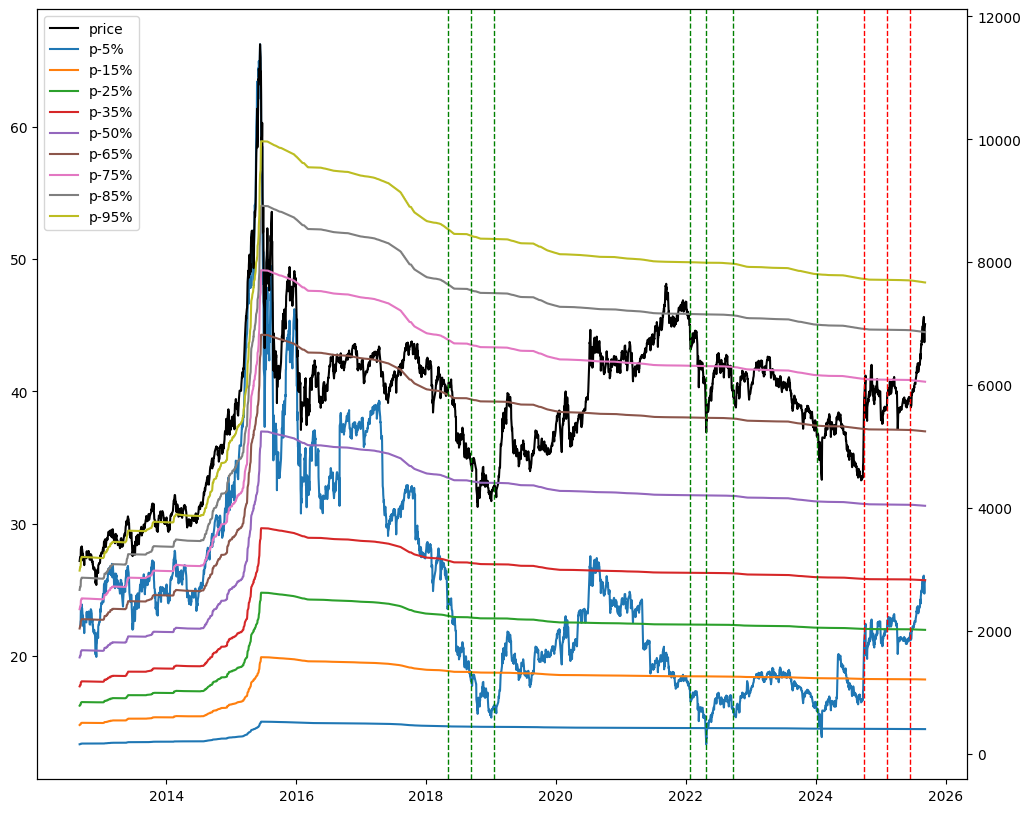

In [37]:
fig, ax1 = plt.subplots(figsize=(12, 10))
ax1.plot(df['tradeDate'], df['peg'], label='PEG')
ax2 = ax1.twinx()
ax2.plot(df['tradeDate'], df['close'], color='black', label='price')

for q in quantiles:
    # ax2.plot(df['tradeDate'], df[f'{q}%'], label=f'{q}%')
    # ax2.plot(df['tradeDate'], df[f'5y-{q}%'], label=f'5y-{q}%')
    # ax2.plot(df['tradeDate'], df[f'10y-{q}%'], label=f'10y-{q}%')
    ax2.plot(df['tradeDate'], df[f'p-{q}%'], label=f'p-{q}%')
trade_str = '''2018-05-02 买
2018-09-10 买
2019-01-18 买
2022-01-25 买
2022-04-22 买
2022-09-23 买
2024-01-08 买
2024-09-30 卖
2025-02-07 卖
2025-06-17 卖
'''

trade_lines = [line.strip() for line in trade_str.split('\n') if line.strip()]

for line in trade_lines:
    date, action = line.split()
    color = 'g' if action == '买' else 'r'
    plt.axvline(x=pd.to_datetime(date), color=color, linestyle='--', linewidth=1)

# plt.xlim(pd.to_datetime('2013-07-01'), pd.to_datetime('2014-12-31'))

plt.legend()
plt.show()


In [21]:
dt = datetime(2025, 9, 5, 9, 30, 0)

row = df[df['tradeDate'] == '2013-09-13']

row[['close', 'peg', '25%', '75%', '5y-5%']]

p5 = row['5y-5%'].item()

type(p5)

float

In [ ]:
month_df = df[df['peg'] <= df['5y-5%']].groupby(pd.Grouper(key='tradeDate', freq='M')).agg(
    count=('peg', 'count'),
    peg平均值=('peg', 'mean')
)

month_df[month_df['count'] > 0]
